In [45]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq,CSV, Statistics

┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[123]:5
└ @ Core In[123]:5


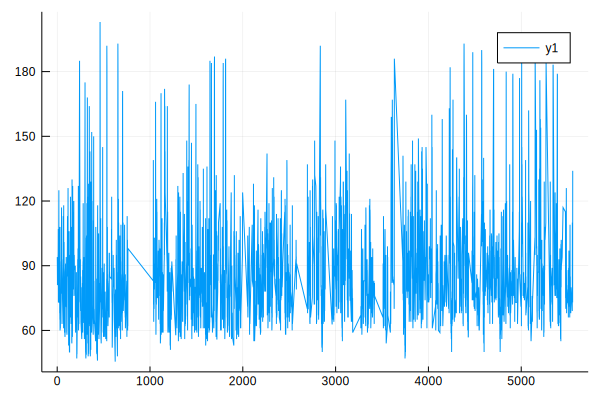

In [123]:
df = CSV.read("/Users/eroesch/Documents/hd.csv", delim=",");
data = df[3]
data_6 = df[3][1:18:end]
keep = map(!iszero, data)
plot(range(1,length(data))[keep], data[keep])

In [124]:
length(data)

5555

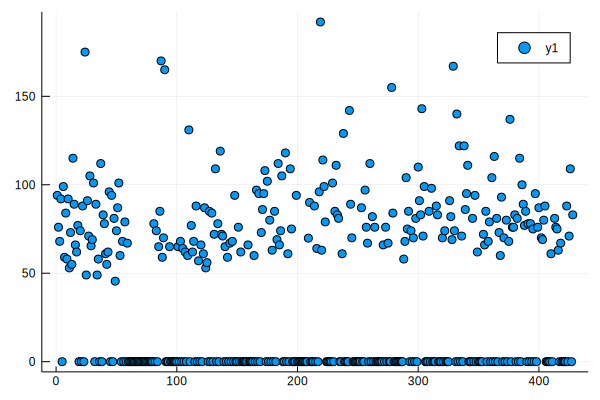

In [79]:
data_1 = df[3][1:13:end]
replace(data_6, 0=>NaN) 
scatter(data_1)

In [201]:
means_per_day =[]
for ind in 1:24:length(data)
    if length(data)>ind+23
        day = data[ind:ind+23]
        keep_d = map(!iszero, day)
        mean_day = mean(day[keep_d])
        if(count(keep_d[i]==false for i in 1:length(keep_d))>12)
            push!(means_per_day,mean_day)
        end
    end
end

In [205]:

x = [51,49,52,54,58,55,56,54,56]
y = ones(length(x));
for i in 2:length(y)
    y[i]=y[i-1]+0.01
end
ode_data = transpose(hcat(x,y))
u0 = [x[1],y[1]]
tspan = (0.0f0, 3.f0)
t = range(tspan[1], tspan[2], length = length(ode_data[1,:]))
species1 = "Resting heart rate"
species2 = "dummy data";

In [206]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

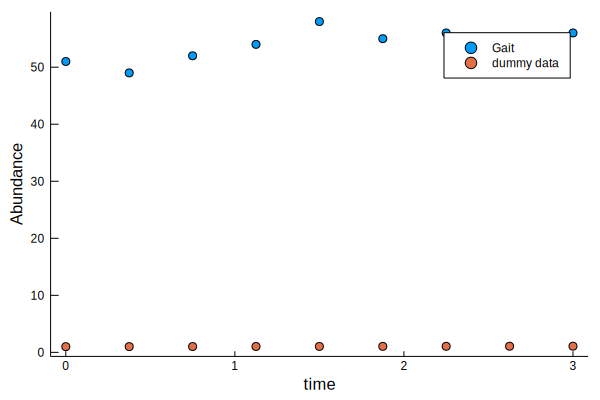

In [207]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1)
scatter!(t, ode_data[2,:], label = species2)

In [246]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(2,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Tsit5(), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 40000
verify = 1000 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.00001)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end


#65 (generic function with 1 method)

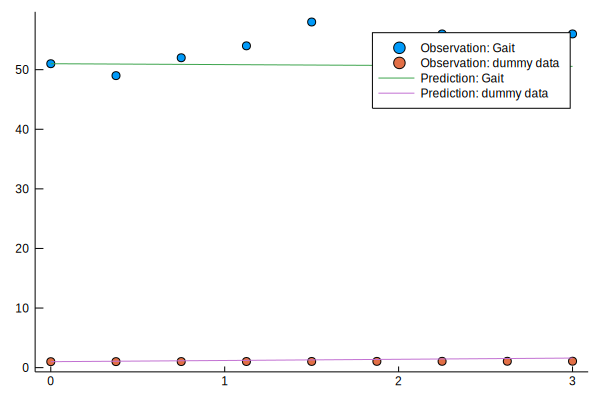

In [247]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [248]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)


309.503659 seconds (220.29 M allocations: 51.891 GiB, 10.88% gc time)


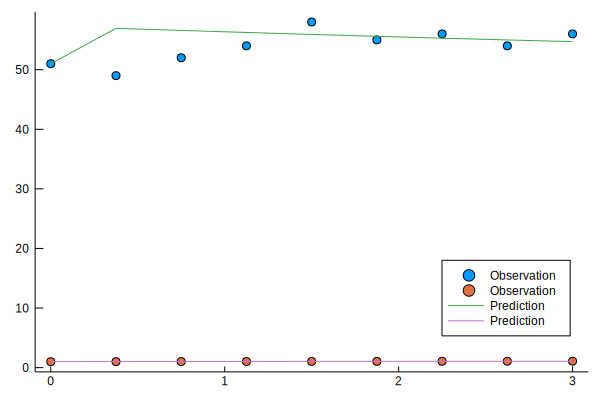

In [249]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation "), grid = "off",  legend=:bottomright)
scatter!(t, ode_data[2,:], label = string("Observation "))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction "))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction "))


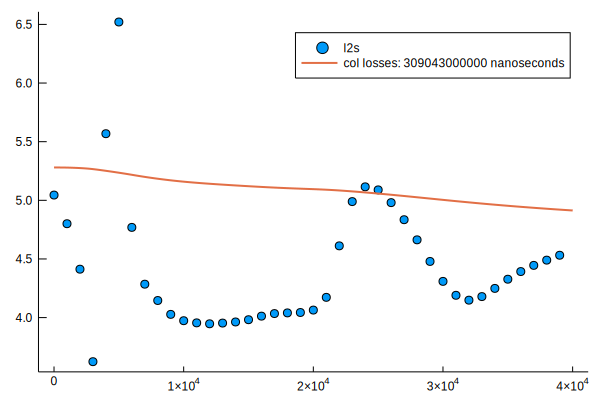

In [250]:
header = string("col losses: ", sa.times[end] - sa.times[1])
scatter(range(1,stop=length(sa.l2s)),log.(sa.l2s),width  =2, label = "l2s", grid = "off")
plot!(range(1,stop=length(sa.losses)),log.(sa.losses), width  =2, label = header)
# 5% of time even with l2s